# Data Exploration

This notebook complete the data exploration phase applicable to the Diabetic Foot Ulcer Dataset.

In [135]:
import os
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from dataset import DFUDataset
from loss import DiceLoss, BCEWithLogitsLoss, IOU
from optimiser import SGD, Adam
from model import UNet, DeepLabV3_MobileNet_V3_Large
from readFiles import ReadFiles
from training import Train

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
import os
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from dataset import DFUDataset
from loss import DiceLoss, BCEWithLogitsLoss
from optimiser import SGD, Adam
from model import UNet, DeepLabV3_MobileNet_V3_Large
from readFiles import ReadFiles
from training import Train

def ReadDirectories():
    print("Reading files from directories.")
    data_path = ""
    # Set training directory
    train_dir = os.path.join(data_path, "dfuc2022/train/images")
    train_mask_dir = os.path.join(data_path, "dfuc2022//train/masks")

    # Set validation directory
    val_dir = os.path.join(data_path, "dfuc2022/val/images")
    val_mask_dir = os.path.join(data_path, "dfuc2022/val/masks")

    # Set test directory
    test_dir = os.path.join(data_path, "dfuc2022/test/")

    train_files = ReadFiles(train_dir)
    train_masks = ReadFiles(train_mask_dir)

    val_files = ReadFiles(val_dir)
    val_masks = ReadFiles(val_mask_dir)

    test_files = ReadFiles(test_dir)
    print("Complete.")

    return train_files, train_masks, val_files, val_masks, test_files

In [3]:
def Transforms():
    transform_train = A.Compose([
        #A.augmentations.dropout.cutout.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.RandomBrightnessContrast(p=0.2),
        #ToTensorV2(),
        #A.augmentations.transforms.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5),
        #A.augmentations.geometric.transforms.ShiftScaleRotate(
        #    shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, p=0.5),
        ToTensorV2(),
    ])

    transform_test = A.Compose([
        ToTensorV2(),
    ])

    return transform_train, transform_test

In [4]:
# Read directories into file lists.
train_files, train_masks, val_files, val_masks, test_files = ReadDirectories()

# Get transformations from Transforms()
transform_train, transform_test = Transforms()

# Generate manual seed for reproducability
torch.manual_seed(42)

# Load dataset
print("Loading datasets...")
train_ds = DFUDataset(train_files, train_masks, transform=transform_train)
val_ds = DFUDataset(val_files, val_masks, transform=transform_test)
print("Complete.")

# Initiate DataLoader
train_iter = DataLoader(train_ds, 1, shuffle=False, pin_memory=True)
val_iter = DataLoader(val_ds, 1, shuffle=False, pin_memory=True)
print("Dataloader Initiated.")

Reading files from directories.
Complete.
Loading datasets...
Complete.
Dataloader Initiated.


In [11]:
image, label = train_ds[0]
label.sum()

tensor(7129.0312)

In [12]:
image,label = train_ds[1]
label.sum()

tensor(767.7843)

## Image Info

In [20]:
channels, height, width = image.shape
print(channels, height, width)

3 480 640


In [21]:
aspect = width / height
print(aspect)

1.3333333333333333


In [33]:
labelSize = float(label.sum())
labelSize

767.7843017578125

In [19]:
image.shape

torch.Size([3, 480, 640])

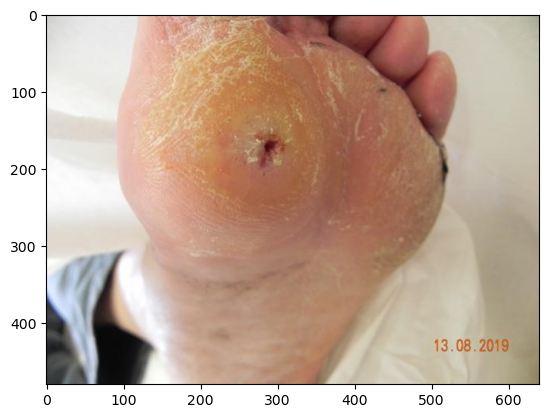

In [34]:
plt.imshow(image.permute(1,2,0));

In [44]:
image, label = next(iter(train_iter))

In [48]:
image.shape

torch.Size([1, 3, 480, 640])

In [268]:
float(label.sum()) / label.flatten().size()[0]

0.27072235107421877

In [269]:
train_data = np.empty([0, 6])
# Loop over the training set
for i, data in enumerate(tqdm(train_iter)):
    image, label = data

    channels, height, width = image.squeeze(0).shape
    aspect = width / height

    labelSize = float(label.sum()) / label.flatten().size()[0]

    train_data = np.r_[train_data, np.array([[i, channels, height, width, aspect, labelSize]])]

train_data = pd.DataFrame(train_data, columns=['i','channels','height','width','aspect','labelSize'])

100%|██████████| 1600/1600 [00:05<00:00, 293.18it/s]


In [270]:
train_data.to_csv('./train_info.csv')

In [271]:
train_data.head()

,i,channels,height,width,aspect,labelSize
0,0.0,3.0,480.0,640.0,1.333333,0.023206
1,1.0,3.0,480.0,640.0,1.333333,0.002499
2,2.0,3.0,480.0,640.0,1.333333,0.004271
3,3.0,3.0,480.0,640.0,1.333333,0.014087
4,4.0,3.0,480.0,640.0,1.333333,0.003536


In [272]:
train_data.describe()

,i,channels,height,width,aspect,labelSize
count,1600.00000,1600.0,1600.0,1600.0,1.600000e+03,1600.000000
mean,799.50000,3.0,480.0,640.0,1.333333e+00,0.023573
std,462.02453,0.0,0.0,0.0,2.309986e-14,0.036684
min,0.00000,3.0,480.0,640.0,1.333333e+00,0.000298
25%,399.75000,3.0,480.0,640.0,1.333333e+00,0.004369
50%,799.50000,3.0,480.0,640.0,1.333333e+00,0.010482
75%,1199.25000,3.0,480.0,640.0,1.333333e+00,0.026463
max,1599.00000,3.0,480.0,640.0,1.333333e+00,0.347518


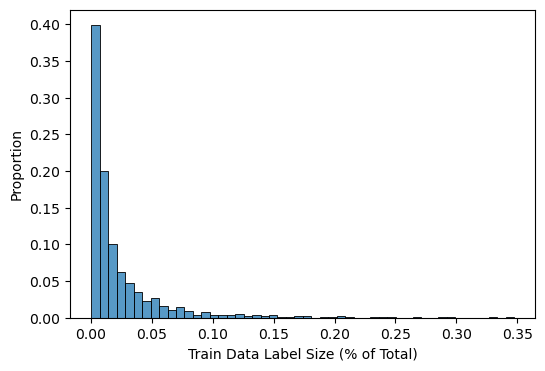

In [275]:
plt.figure(figsize=(6,4))
sns.histplot(train_data['labelSize'], bins=50, stat='proportion');
plt.xlabel('Train Data Label Size (% of Total)');
plt.ylim([0,0.42]);

plt.show()

In [276]:
val_data = np.empty([0, 6])
# Loop over the training set
for i, data in enumerate(tqdm(val_iter)):
    image, label = data

    channels, height, width = image.squeeze(0).shape
    aspect = width / height

    labelSize = float(label.sum()) / label.flatten().size()[0]

    val_data = np.r_[val_data, np.array([[i, channels, height, width, aspect, labelSize]])]

val_data = pd.DataFrame(val_data, columns=['i','channels','height','width','aspect','labelSize'])

100%|██████████| 400/400 [00:01<00:00, 307.71it/s]


In [277]:
val_data.describe()

,i,channels,height,width,aspect,labelSize
count,400.000000,400.0,400.0,400.0,4.000000e+02,400.000000
mean,199.500000,3.0,480.0,640.0,1.333333e+00,0.024022
std,115.614301,0.0,0.0,0.0,5.780390e-15,0.037331
min,0.000000,3.0,480.0,640.0,1.333333e+00,0.000459
25%,99.750000,3.0,480.0,640.0,1.333333e+00,0.004323
50%,199.500000,3.0,480.0,640.0,1.333333e+00,0.009951
75%,299.250000,3.0,480.0,640.0,1.333333e+00,0.026014
max,399.000000,3.0,480.0,640.0,1.333333e+00,0.310801


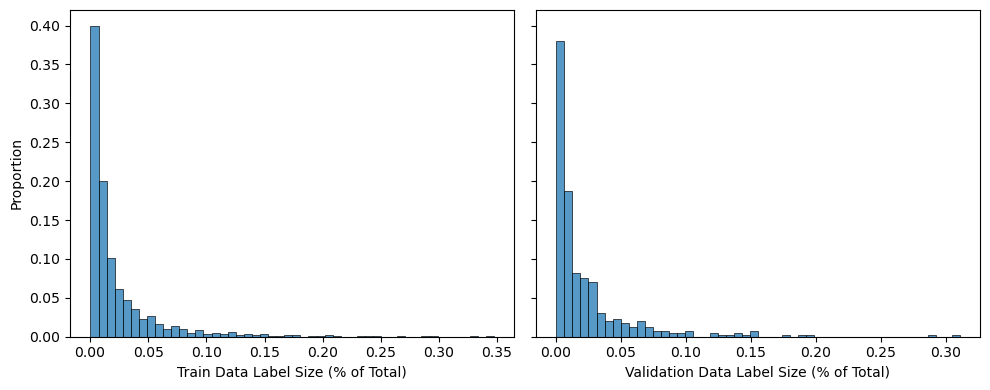

In [280]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

sns.histplot(train_data['labelSize'], bins=50, stat='proportion', ax=axs[0]);
axs[0].set_xlabel('Train Data Label Size (% of Total)');
axs[0].set_ylim([0,0.42]);

sns.histplot(val_data['labelSize'], bins=50, stat='proportion', ax=axs[1]);
axs[1].set_xlabel('Validation Data Label Size (% of Total)');

plt.tight_layout();
plt.show()

In [281]:
print(pd.concat([train_data.drop(columns=['i','aspect']), val_data.drop(columns=['i','aspect'])], axis=0).describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  channels &  height &   width &    labelSize \\
\midrule
count &    2000.0 &  2000.0 &  2000.0 &  2000.000000 \\
mean  &       3.0 &   480.0 &   640.0 &     0.023663 \\
std   &       0.0 &     0.0 &     0.0 &     0.036806 \\
min   &       3.0 &   480.0 &   640.0 &     0.000298 \\
25\%   &       3.0 &   480.0 &   640.0 &     0.004366 \\
50\%   &       3.0 &   480.0 &   640.0 &     0.010367 \\
75\%   &       3.0 &   480.0 &   640.0 &     0.026339 \\
max   &       3.0 &   480.0 &   640.0 &     0.347518 \\
\bottomrule
\end{tabular}



/var/folders/94/1mgtxbsd2_781zg_4p5613q40000gn/T/ipykernel_98739/3038953249.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([train_data.drop(columns=['i','aspect']), val_data.drop(columns=['i','aspect'])], axis=0).describe().to_latex())


In [213]:
lower, upper = np.percentile(train_data['labelSize'], [1,99])
print('Lower bound: {}, Upper bound: {}'.format(lower, upper))

smallLabel = train_data.loc[train_data['labelSize'] < lower]
largeLabel = train_data.loc[train_data['labelSize'] > upper]

iSmall = smallLabel['i'].astype('int').head(3)
iLarge = largeLabel['i'].astype('int').head(3)

Lower bound: 224.6687889099121, Upper bound: 59334.79613281249


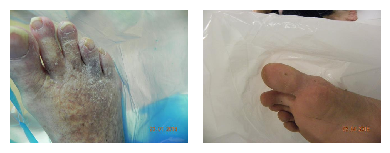

In [291]:
fig, axs = plt.subplots(1, 2, figsize=(4, 4))

for i, j in zip(range(0,2), iSmall):
    image, label = train_ds[j]

    axs[i].imshow(image.permute(1,2,0), interpolation='nearest')
    axs[i].axis('off')
    #axs[1, i].imshow(label, interpolation='nearest')
    #axs[1, i].axis('off')

plt.tight_layout()
plt.show()

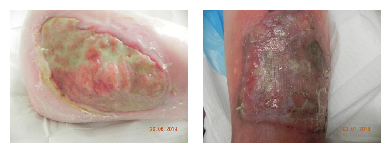

In [292]:
fig, axs = plt.subplots(1, 2, figsize=(4, 4))

for i, j in zip(range(0,2), iLarge):
    image, label = train_ds[j]

    axs[i].imshow(image.permute(1,2,0), interpolation='nearest')
    axs[i].axis('off')
    #axs[1, i].imshow(label, interpolation='nearest')
    #axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [293]:
mid_low, mid_high = np.percentile(train_data['labelSize'], [47.5,52.5])
print('Lower bound: {}, Upper bound: {}'.format(lower, upper))

midLabel = train_data.loc[(train_data['labelSize'] < mid_high) & (train_data['labelSize'] > mid_low)]

iMid = midLabel['i'].astype('int').head(3)

Lower bound: 224.6687889099121, Upper bound: 59334.79613281249


In [294]:
iMid

12    12
15    15
19    19
Name: i, dtype: int64

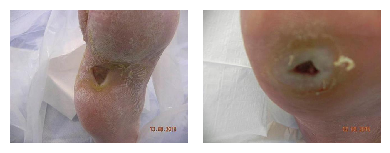

In [295]:
fig, axs = plt.subplots(1, 2, figsize=(4, 4))

for i, j in zip(range(0,2), iMid):
    image, label = train_ds[j]

    axs[i].imshow(image.permute(1,2,0), interpolation='nearest')
    axs[i].axis('off')
    #axs[1, i].imshow(label, interpolation='nearest')
    #axs[1, i].axis('off')

plt.tight_layout()
plt.show()